# Foundations of Data Science - Final Project
## A Predictive Modeling and Analysis on Causes of Death by Opioid Prescription
### Submission By:

<ul>
    <li>Akshay Prakash Tambe (apt321@nyu.edu)</li>
    <li>Aditya Bhatt (apb462@nyu.edu)</li>
</ul>

# Data Science for Social Good

<b style="color:red">Problem:</b> Opioid Prescription helps to treat moderate to severe pain but it also leads to addiction
and hence, people misuse it by consuming it at higher rate. Overdose of Opioids leads to death.
1. How to improve ways the opioids are prescribed?
2. How to reduce the death toll due to drug overdose in North America?

<b style="color:green">Goal:</b> Detect opium components in the data and predict prescribers with opioid prescriptions
which may lead to drug addiction.

<b style="color:blue">Data:</b> Prescription data with drug components, medicare domain, opium drug list, state-wise
overdose deaths.

<b style="color:orange">Target Variable:</b> Opioid Prescriber or not?

<b style="color:purple">Impact:</b> Model is able to predict prescriber with opioid prescription and
individual chemicals and features of high importance causing opioid addiction.

# Data Loading

- Drug Prescriber Dataset: https://www.cms.gov/ - “Medicare Provider Utilization and Payment Data: Part D Prescriber”
- Data on Overdose Deaths: https://www.data.gov/ - “Accidental and Drug Related Deaths”
- List of drugs classified as opiates: https://www.cdc.gov/drugoverdose/resources/data.html

In [56]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load Drug Prescriber Data in Pandas Dataframe
drug_prescriber_df = pd.read_csv("prescriber_information.csv")
drug_prescriber_df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [57]:
# Load Overdose Deaths Data in Pandas Dataframe
overdose_df = pd.read_csv("overdose_deaths.csv")
overdose_df.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


In [58]:
# Load Overdose Deaths Data in Pandas Dataframe
opioid_df = pd.read_csv("opioid_drug_list.csv")
opioid_df.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


# Data Preprocessing

In [59]:
# Check for Missing Values
print("Drug Prescriber Data= ", drug_prescriber_df.isnull().values.any())
print("Overdose Data= ", overdose_df.isnull().values.any())
print("Drug List Data= ", opioid_df.isnull().values.any())

Drug Prescriber Data=  True
Overdose Data=  False
Drug List Data=  False


<div style="color:blue">
There are some missing values in Drug Prescriber Data.
<br/>
Now, lets check for Specific Columns for Missing Values in Drug Prescriber Data.
</div>

In [60]:
# Check for Specific Columns for Missing Values in Drug Prescriber Data
#pd.options.display.max_rows = 4000
drug_prescriber_df.isnull().sum()

NPI                                 0
Gender                              0
State                               0
Credentials                       763
Specialty                           0
ABILIFY                             0
ACETAMINOPHEN.CODEINE               0
ACYCLOVIR                           0
ADVAIR.DISKUS                       0
AGGRENOX                            0
ALENDRONATE.SODIUM                  0
ALLOPURINOL                         0
ALPRAZOLAM                          0
AMIODARONE.HCL                      0
AMITRIPTYLINE.HCL                   0
AMLODIPINE.BESYLATE                 0
AMLODIPINE.BESYLATE.BENAZEPRIL      0
AMOXICILLIN                         0
AMOX.TR.POTASSIUM.CLAVULANATE       0
AMPHETAMINE.SALT.COMBO              0
ATENOLOL                            0
ATORVASTATIN.CALCIUM                0
AVODART                             0
AZITHROMYCIN                        0
BACLOFEN                            0
BD.ULTRA.FINE.PEN.NEEDLE            0
BENAZEPRIL.H

<div style="color:blue">
Missing Values found only in `Credentials` Column.
</div>

In [61]:
# Check for Number of States in Two Datasets
set(drug_prescriber_df.State.unique()) - set(overdose_df.Abbrev.unique())

{'AA', 'AE', 'DC', 'GU', 'PR', 'VI', 'ZZ'}

<div style="color:blue">
Findings from the datasets:
<ul>
    <li>Missing Values found only in Credentials Column from Drug Prescriber Data -> Replace Missing Values with String Value.</li>
    <li>Mismatch in number of states in Drug Prescriber and Overdose Data -> Clean Up States from Prescriber Data to match the list of states in Overdose Death Data.</li>
    <li>Quantitative Value stored as a String in Overdose Data -> Remove Commas in Numerical Values.</li>
</ul>
Perform Data Cleaning after findings.
</div>

In [62]:
import numpy as np
# Drug Prescriber Dataset Cleaning Credentials Column - Replace Missing Values with String Value
drug_prescriber_df.Credentials = drug_prescriber_df.Credentials.fillna('UNKNOWN')

# Clean Up States from Prescriber Data to match the list of states in Overdose Death Data
drug_prescriber_df= drug_prescriber_df[drug_prescriber_df.State != 'AE']
drug_prescriber_df = drug_prescriber_df[drug_prescriber_df.State != 'ZZ']
drug_prescriber_df = drug_prescriber_df[drug_prescriber_df.State != 'AA']
drug_prescriber_df = drug_prescriber_df[drug_prescriber_df.State != 'PR']
drug_prescriber_df = drug_prescriber_df[drug_prescriber_df.State != 'GU']
drug_prescriber_df = drug_prescriber_df[drug_prescriber_df.State != 'VI']

# Overdoses Data - Removing Commas in Numerical Values
overdose_df['Deaths'] = overdose_df['Deaths'].str.replace(',', '')
overdose_df['Deaths'] = overdose_df['Deaths'].astype(int)
overdose_df['Population'] = overdose_df['Population'].str.replace(',', '')
overdose_df['Population'] = overdose_df['Population'].astype(int)

# Calculating Death Density statewise with respect to population
overdose_df['Deaths/Population'] = (overdose_df['Deaths']/overdose_df['Population'])
overdose_df.head()

,State,Population,Deaths,Abbrev,Deaths/Population
0,Alabama,4833722,723,AL,0.000150
1,Alaska,735132,124,AK,0.000169
2,Arizona,6626624,1211,AZ,0.000183
3,Arkansas,2959373,356,AR,0.000120
4,California,38332521,4521,CA,0.000118


# Data Exploration - Descriptive Analysis


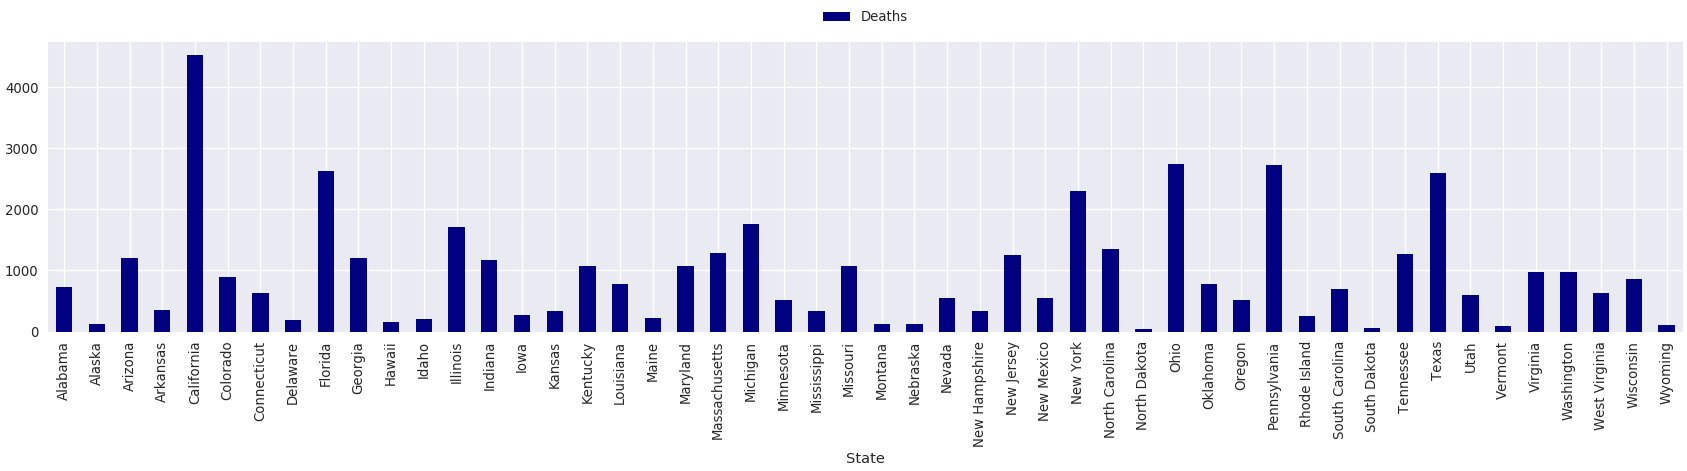

In [63]:
# Pixiedust is used for creating visualizations
import pixiedust

# Investigate Number of Deaths by Opioid w.r.t US States
display(overdose_df)


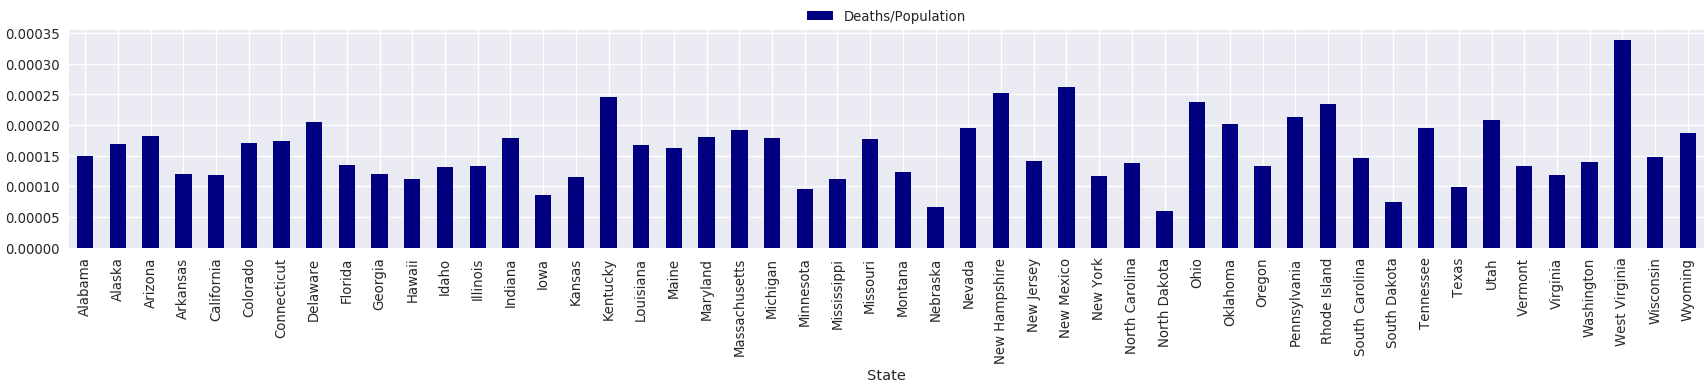

In [64]:
# Investigate Number of Deaths by Opioid w.r.t Population and US States
display(overdose_df)

![title](Visualizations/Number_of_Deaths_Dashboard.png)
<div style="color:blue">
The above visualizations considers the density for comparison as states can be of high population.
<br/>
Insights:
<ul>
<li>California has the highest number of deaths - 4521.</li>
<li>West Virginia, New Mexico, New Hampshire, Kentucky, Ohio and Rhode Island have highest number of death rates.</li>
</ul>
</div>

In [65]:
# Male-Female Ratio in Prescriber List
drug_prescriber_df.groupby('Gender').size() / drug_prescriber_df.groupby('Gender').size().sum()

Gender
F    0.378166
M    0.621834
dtype: float64

In [66]:
# Calculate Percentage of Opioid Prescription
drug_prescriber_df.groupby('Opioid.Prescriber').size() / drug_prescriber_df.groupby('Opioid.Prescriber').size().sum()

Opioid.Prescriber
0    0.41282
1    0.58718
dtype: float64

## Stats on Credentials and Specialities
![title](Visualizations/Opiod_Stats.png)

## Identifying Opioids from Prescriber Dataset

In [67]:
# Identifying Opioids from Prescriber Dataset
import re

opioid_list = list(re.sub(r'[-\s]','.',x) for x in opioid_df.values[:,0])
prescribed_opiod_drug_list = list(set(opioid_list) & set(drug_prescriber_df.columns))

for i, drug in enumerate(prescribed_opiod_drug_list):
    print (i+1, drug)

1 OXYCONTIN
2 HYDROMORPHONE.HCL
3 METHADONE.HCL
4 MORPHINE.SULFATE.ER
5 ACETAMINOPHEN.CODEINE
6 OXYCODONE.HCL
7 FENTANYL
8 MORPHINE.SULFATE
9 TRAMADOL.HCL
10 OXYCODONE.ACETAMINOPHEN
11 HYDROCODONE.ACETAMINOPHEN


<div style="color:blue">
<p>Insights:</p>
<ol>
    <li>There are 11 opioid drugs out of the 250 drugs mentioned in the prescribers data.</li>
    <li>60% of the prescribers on this list are opioid prescribers</li>
</ol>
</div>

## Prescribed Opioids vs Total Prescriptions

In [68]:
# No. of opioid prescribers out of the total prescribers
print("No. of opioid prescribers out of the total prescribers = "\
      +str(float(drug_prescriber_df['Opioid.Prescriber'].sum())*100/drug_prescriber_df.shape[0])+"%")

No. of opioid prescribers out of the total prescribers = 58.71804192414879%


In [69]:
# Make a copy of dataframe for further analysis
prescriber_stat_df = drug_prescriber_df.copy()

# Create New Features from existing data
prescriber_stat_df['No_of_Opioids'] = prescriber_stat_df.apply(lambda x: sum(x[prescribed_opiod_drug_list]), axis=1)
prescriber_stat_df['No_of_Prescriptions'] = prescriber_stat_df.apply(lambda x: sum(x.iloc[5:255]), axis=1)
prescriber_stat_df['OpiodPrescribedRatio'] = prescriber_stat_df.apply(lambda x: float(x['No_of_Opioids'])/x['No_of_Prescriptions'], axis=1)
prescriber_stat_df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,No_of_Opioids,No_of_Prescriptions,OpiodPrescribedRatio
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,1,17,29,0.586207
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,35,1,362,1418,0.255289
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,25,0,0,289,0.000000
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,1,559,1757,0.318156
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,17,28,0,0,0,1,66,179,0.368715


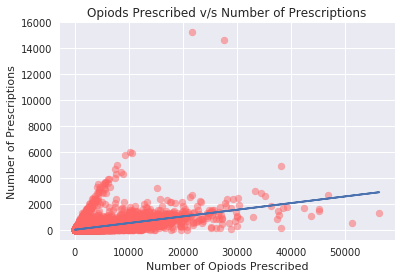

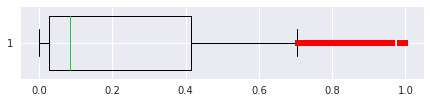

In [70]:
import matplotlib.pyplot as plt

N = prescriber_stat_df['No_of_Opioids'].shape[0]
X = prescriber_stat_df['No_of_Prescriptions']
Y = prescriber_stat_df['No_of_Opioids']
plot_colors = (255/255, 102/255, 102/255)
 
# Plotting Scatter Plot
plt.scatter(X, Y, c=plot_colors, alpha=0.5)
m, b = np.polyfit(X, Y, 1)
plt.plot(X, m*X + b, '-')
plt.title('Opiods Prescribed v/s Number of Prescriptions')
plt.xlabel('Number of Opiods Prescribed')
plt.ylabel('Number of Prescriptions')
plt.show()

# Fraction of Opiods Prescribed by Opioid Prescribers Box Plot
opioid_fraction_df = prescriber_stat_df.loc[prescriber_stat_df['Opioid.Prescriber'] > 0, 'OpiodPrescribedRatio']
figure = plt.figure(figsize=(7, 5))
axes = figure.add_subplot(1, 1, 1)
axes.boxplot(opioid_fraction_df, 0, 'rs', 0, 0.75, widths=[0.75])
plt.subplots_adjust(left=0.1, right=0.9, top=0.6, bottom=0.4)
plt.show()

<div style="color:blue">
<p>Insights:</p>
<ul>
<li>If a prescriber increase the number of prescriptions, it is likely to increase the opioid prescription by 10% (Box Plot Value).</li>
</ul>
</div>

# Opioid Prescribers by Gender

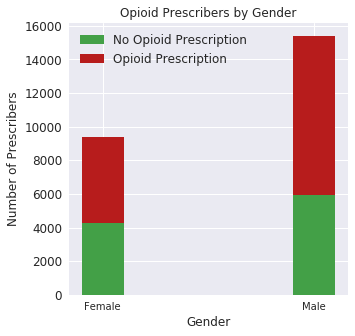

In [71]:
gender_count = np.array(list(prescriber_stat_df[['Gender','NPI']].groupby('Gender').count()['NPI']))

gender_count = np.append([gender_count],[list(prescriber_stat_df.loc[prescriber_stat_df['Opioid.Prescriber'] > 0,\
                            ['Gender','NPI']].groupby('Gender').count()['NPI'])], axis=0)

gender_count[0] = gender_count[0] - gender_count[1]

figure = plt.gcf()
figure.set_size_inches(5, 5)

count = gender_count[0]
N = count.shape[0]
count_dist = np.arange(N)
width = 0.2

plot1 = plt.bar(count_dist, gender_count[0], width, color='#43A047')
plot2 = plt.bar(count_dist, gender_count[1], width, bottom=gender_count[0], color='#B71C1C')

plt.yticks(fontsize=12)
plt.ylabel("Number of Prescribers", fontsize=12)
plt.xticks(count_dist,["Female","Male"])
plt.xlabel('Gender', fontsize=12)
plt.title("Opioid Prescribers by Gender")
plt.legend([plot1[0], plot2[0]], ["No Opioid Prescription","Opioid Prescription"], fontsize=12, fancybox=True)
plt.show()

<div style="color:blue">
<p>Insights:</p>
<ul>
<li>Prescribed Opioids is higher in the case of Male.</li>
</ul>
</div>

# Opioid Prescribers by State

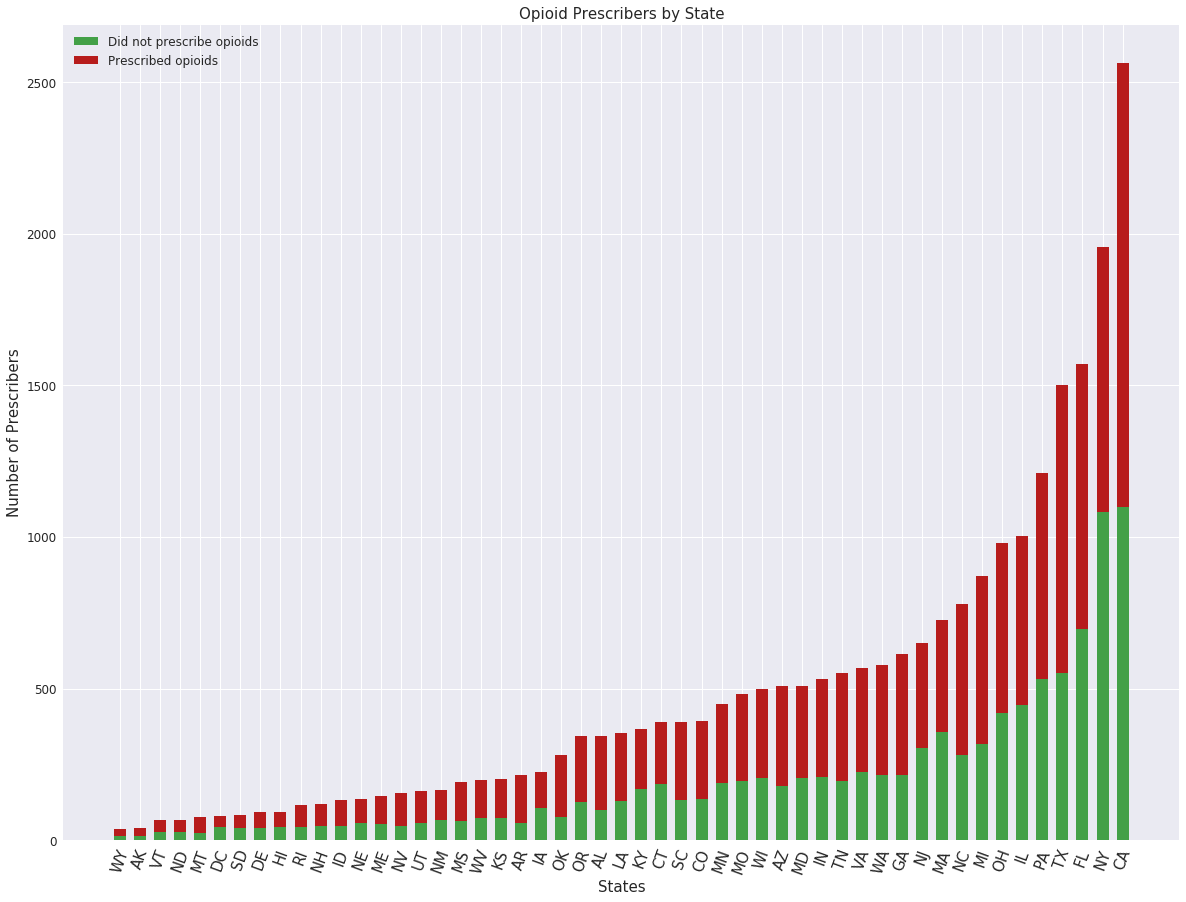

In [72]:
state_count = pd.DataFrame(prescriber_stat_df[['State','NPI']].groupby('State').count())

state_count.reset_index(level=0, inplace=True)

state_count.columns = ['State', 'Total_Prescribers']

state_count_PrescribedOpiods = pd.DataFrame(prescriber_stat_df.loc[prescriber_stat_df['Opioid.Prescriber'] > 0\
                                                                   ,['State','NPI']].groupby('State').count())
state_count_PrescribedOpiods.reset_index(level=0, inplace=True)
state_count_PrescribedOpiods.columns = ['State', 'Opiod_Prescribers']
state_count = pd.merge(state_count, state_count_PrescribedOpiods,  how='left', on="State")

state_count = state_count.fillna(0)

state_count = state_count.sort_values('Total_Prescribers')

figure = plt.gcf()
figure.set_size_inches( 20, 15)

N = state_count.shape[0]
count_dist = np.arange(N)
width = 0.6

plot1 = plt.bar(count_dist, state_count['Total_Prescribers'] - state_count['Opiod_Prescribers'], width, color='#43A047')
plot2 = plt.bar(count_dist, state_count['Opiod_Prescribers'], width, bottom=state_count['Total_Prescribers'] - \
             state_count['Opiod_Prescribers'], color='#B71C1C')

plt.yticks(fontsize=12)
plt.ylabel("Number of Prescribers", fontsize=15)
plt.xticks(count_dist, state_count['State'], fontsize=15, rotation=70)
plt.xlabel('States', fontsize=15)
plt.title("Opioid Prescribers by State", fontsize=15)
plt.legend([plot1[0], plot2[0]], ["Did not prescribe opioids","Prescribed opioids"], fontsize=12, fancybox=True)
plt.show()

<div style="color:blue">
Insights:
<br/>
<ul>
<li>States like CA, NY, FL, TX have higher opioid prescribers which
corresponds with high death rates reported due to opioid overdose.</li>
</ul>
</div>

# Opioid Prescribers by Specialty (Sorted by num of Opioids prescribed)

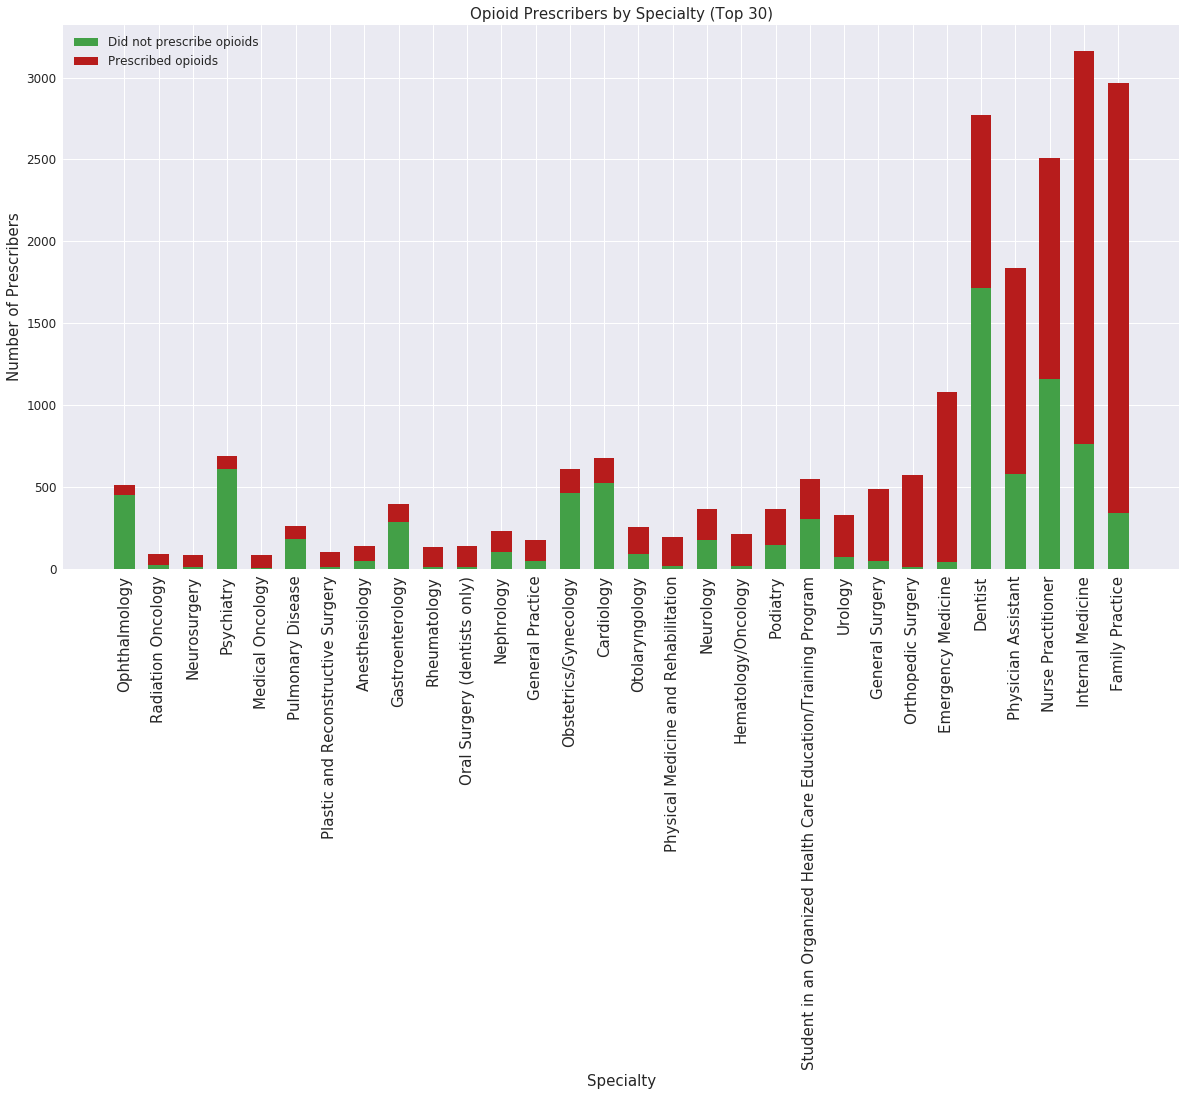

In [73]:
speciality_count = pd.DataFrame(prescriber_stat_df[['Specialty','NPI']].groupby('Specialty').count())

speciality_count.reset_index(level=0, inplace=True)

speciality_count.columns = ['Specialty', 'Total_Prescribers']

speciality_count_PrescribedOpiods = pd.DataFrame(prescriber_stat_df.loc[prescriber_stat_df['Opioid.Prescriber'] > 0,\
                                                                        ['Specialty','NPI']].groupby('Specialty').count())
speciality_count_PrescribedOpiods.reset_index(level=0, inplace=True)

speciality_count_PrescribedOpiods.columns = ['Specialty', 'Opiod_Prescribers']
speciality_count = pd.merge(speciality_count, speciality_count_PrescribedOpiods,  how='left', on="Specialty")

speciality_count = speciality_count.fillna(0)

speciality_count = speciality_count.sort_values('Opiod_Prescribers')

speciality_count = speciality_count[-30::]

figure = plt.gcf()
figure.set_size_inches( 20, 10)

N = speciality_count.shape[0]
count_dist = np.arange(N)
width = 0.6

plot1 = plt.bar(count_dist, speciality_count['Total_Prescribers'] - speciality_count['Opiod_Prescribers'], width, color='#43A047')
plot2 = plt.bar(count_dist, speciality_count['Opiod_Prescribers'], width, bottom=speciality_count['Total_Prescribers'] - \
             speciality_count['Opiod_Prescribers'], color='#B71C1C')

plt.yticks(fontsize=12)
plt.ylabel("Number of Prescribers", fontsize=15)
plt.xticks(count_dist, speciality_count['Specialty'], fontsize=15, rotation=90)
plt.xlabel('Specialty', fontsize=15)
plt.title("Opioid Prescribers by Specialty (Top 30)", fontsize=15)
plt.legend([plot1[0], plot2[0]], ["Did not prescribe opioids","Prescribed opioids"], fontsize=12, fancybox=True)


<div style="color:blue">
Insights:
<br/>
<ul>
<li>Use of opioids is higher in specialties which involve the use of
Painkillers/Inhibitors, based on the top specialities.</li>
</ul>
</div>

# Principal Component Analysis

Text(0.5,1,'PCA Components with Explained Variance')

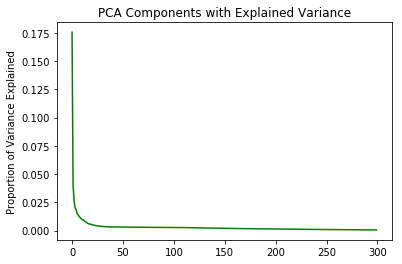

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

specialty = pd.DataFrame(prescriber_stat_df.groupby(['Specialty']).count()['NPI']).sort_values('NPI')

specialty.loc[specialty['NPI'] < 40].shape


rare_specialty = list(specialty.loc[specialty['NPI'] < 40].index)

prescriber_stat_df.loc[prescriber_stat_df['Specialty'].isin(rare_specialty),'Specialty'] \
= prescriber_stat_df.loc[prescriber_stat_df['Specialty'].isin(rare_specialty),'Specialty']\
.apply(lambda x: 'Surgery' if 'Surgery' in list(x.split( )) else 'Other')

prescriber_stat_pca_df = prescriber_stat_df.drop( ['NPI','Credentials'], axis=1)

prescriber_stat_pca_df = pd.get_dummies(prescriber_stat_pca_df, columns=['Gender','Specialty','State'], drop_first=True)

# Convert to numpy arrays
X = prescriber_stat_pca_df.values

# Fit and Transform
scaler = StandardScaler()
scaler.fit(X)
X_scaled_tranform = scaler.transform(X)
pca = PCA(n_components=300)
pca.fit(X_scaled_tranform)

# Explained Variance
variance = pca.explained_variance_ratio_

# Plotting PCA Components with Explained Variance
plt.plot(variance, color='g')
plt.ylabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('PCA Components with Explained Variance')

<div style="color:blue">
Looking from the above plot, we considered 20 significant components
</div>

In [74]:
# Perform PCA for 20 Components
pca = PCA(n_components=20)
X1 = pca.fit_transform(X_scaled_tranform)
print ("Variance explained by first 10 factors = %s" \
       % (pca.explained_variance_ratio_[0:9].sum()/pca.explained_variance_ratio_.sum()))

Variance explained by first 10 factors = 0.7990834683939806


<div style="color:blue">
As first 10 factors explains 79% of the variance, we consider these factors for PCA Analysis
</div>

In [75]:
# Factor Loading
# Selecting the top 10 factors in terms of explained variance
pca_factors = pd.DataFrame(pca.components_, columns=prescriber_stat_pca_df.columns)
pca_factors = pca_factors.loc[0:9]
pca_factors

,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.037425,0.043125,0.026385,0.070814,0.063719,0.069632,0.098693,0.070281,0.052133,0.079438,...,-0.000014,0.002554,-0.000983,-0.002036,-0.000818,-0.001077,-0.003044,-0.001075,0.001874,0.000437
1,0.199734,-0.018672,-0.008326,-0.024340,0.014890,-0.034764,-0.036206,0.077885,-0.046544,0.038059,...,0.003658,-0.000433,-0.001584,0.001930,0.000754,0.002198,0.002382,0.001833,-0.000593,-0.000467
2,-0.072716,0.044869,0.021971,0.018033,-0.008108,0.018201,0.004539,0.045440,-0.110852,0.077062,...,-0.002428,0.007317,0.000816,0.002747,0.000028,0.001241,0.002691,-0.001356,-0.000410,0.002081
3,-0.002859,-0.026621,-0.029778,-0.077723,0.015175,-0.079000,-0.032280,-0.014227,0.194486,-0.019435,...,0.002262,-0.000914,-0.003996,-0.002100,-0.001384,0.000845,0.003514,0.004476,-0.003277,-0.000723
4,0.047247,0.014200,0.001380,-0.000805,-0.094955,0.020061,0.009504,0.125591,0.006750,0.060447,...,-0.001595,0.000328,-0.004786,-0.002029,-0.000400,0.000923,-0.000168,0.001226,0.002926,-0.002854
5,0.013563,-0.000194,0.037303,-0.002060,-0.020917,0.010120,-0.003744,0.031591,-0.003191,0.004069,...,-0.001946,-0.002492,0.005672,-0.006165,-0.003719,0.002784,-0.006477,-0.004915,-0.003190,-0.003110
6,0.009453,-0.030790,-0.042929,-0.085096,0.007264,-0.012982,-0.021798,-0.040518,-0.002242,-0.009686,...,-0.001973,-0.000463,-0.001259,-0.003210,0.002284,-0.001208,0.003776,0.004664,-0.005219,-0.000795
7,0.026042,0.001697,-0.034536,0.083721,0.032409,0.024298,-0.054735,-0.036489,0.038030,-0.032326,...,-0.004394,-0.012819,0.011948,-0.002433,-0.001544,-0.004127,-0.010856,-0.010440,0.002161,-0.004275
8,0.057103,-0.023396,-0.005409,-0.088479,-0.031724,-0.021187,-0.014309,0.003917,0.031390,-0.062321,...,-0.003753,0.002426,0.004818,-0.000573,-0.008010,0.000865,-0.007639,-0.010217,0.004181,0.004595
9,-0.059437,-0.032038,-0.015545,-0.149951,0.048498,-0.009104,0.030127,0.027423,-0.025824,0.093087,...,0.001135,0.010158,0.013969,0.011760,0.001849,-0.003338,-0.006823,-0.010935,0.000323,0.001984


In [76]:
# Important factors with higher weightage
latent_factors = list(set(pd.DataFrame(pca_factors.max())[pd.DataFrame(pca_factors.max()> 0.2)[0]].index)\
                  .union(set(pd.DataFrame(pca_factors.min())[pd.DataFrame(pca_factors.min()< -0.2)[0]].index)))
pd.DataFrame(latent_factors)

,0
0,LEVEMIR.FLEXPEN
1,AVODART
2,PRIMIDONE
3,RESTASIS
4,DORZOLAMIDE.TIMOLOL
5,VESICARE
6,Specialty_Ophthalmology
7,BRIMONIDINE.TARTRATE
8,Specialty_Urology
9,TAMSULOSIN.HCL


In [77]:
pca_factors_subset = pca_factors[latent_factors]
pca_factors_subset.head()

,LEVEMIR.FLEXPEN,AVODART,PRIMIDONE,RESTASIS,DORZOLAMIDE.TIMOLOL,VESICARE,Specialty_Ophthalmology,BRIMONIDINE.TARTRATE,Specialty_Urology,TAMSULOSIN.HCL,...,TIMOLOL.MALEATE,Specialty_Neurology,TRAVATAN.Z,MORPHINE.SULFATE.ER,BD.ULTRA.FINE.PEN.NEEDLE,OXYCODONE.HCL,HUMALOG,VOLTAREN,LANTUS.SOLOSTAR,LOVAZA
0,0.063771,0.030504,0.038301,0.002576,-0.000715,0.052875,-0.007409,0.003974,-0.002034,0.061667,...,0.000852,-0.000416,0.003008,0.019621,0.055437,0.022462,0.059714,0.039927,0.069814,0.043000
1,-0.024261,-0.015848,0.041282,0.002725,0.004107,-0.006929,-0.000078,0.008065,-0.003391,-0.017083,...,0.004437,0.031333,0.006777,0.028823,-0.041010,0.024970,-0.003637,-0.016172,-0.033964,-0.042035
2,0.003735,0.001097,0.015556,-0.005780,-0.010548,0.003897,-0.007617,-0.011433,0.003777,0.005128,...,-0.010877,0.016175,-0.011063,0.231342,0.009342,0.209539,-0.001332,0.052642,0.009913,-0.028229
3,-0.081055,-0.039929,0.028056,0.003248,0.006139,-0.032141,0.002109,0.008835,-0.026175,-0.052085,...,0.006665,0.023799,0.007612,0.158396,-0.117661,0.134794,-0.070345,-0.010703,-0.106128,-0.005233
4,-0.022370,-0.050923,-0.103461,-0.058157,-0.092150,-0.079001,-0.058792,-0.102746,-0.057571,-0.073235,...,-0.095087,-0.060912,-0.099243,0.046539,0.019195,0.043484,-0.088398,0.017604,-0.001407,0.046662


[]

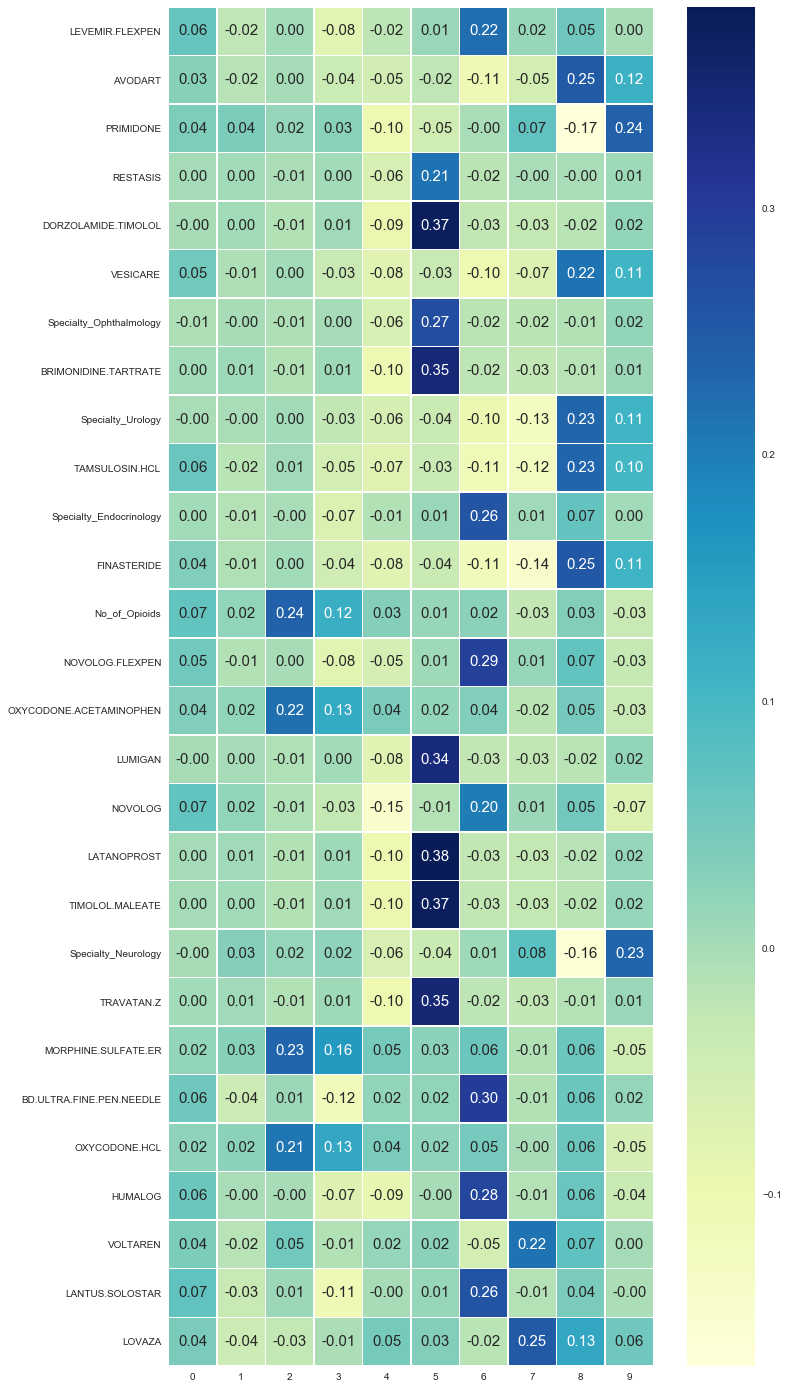

In [78]:
# Heatmap
import seaborn as sns
sns.set(rc={'figure.figsize':(12,25)})
sns.heatmap(pca_factors_subset.T, cmap='YlGnBu', cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, linewidths=0.5)
plt.plot()

<div style="color:blue">
Insights From Co-relation Matrix:
<ul>
<li>Latanoprost (0.38) -> It is used to treat high pressure inside the eye due to glaucoma (open angle type) 
or other eye diseases.</li>
</ul>
</div>

# Feature Engineering

In [79]:
# Remove Spacing and Special Characters from Drug Name and Replace it with .
import re
drug_name = opioid_df['Drug Name']
drug_name = drug_name.apply(lambda x:re.sub("\ |-",".",str(x)))
drug_name

0                             ABSTRAL
1               ACETAMINOPHEN.CODEINE
2                               ACTIQ
3                 ASCOMP.WITH.CODEINE
4      ASPIRIN.CAFFEINE.DIHYDROCODEIN
5                              AVINZA
6                    BELLADONNA.OPIUM
7                   BUPRENORPHINE.HCL
8      BUTALB.ACETAMINOPH.CAFF.CODEIN
9      BUTALB.CAFF.ACETAMINOPH.CODEIN
10        BUTALBITAL.COMPOUND.CODEINE
11               BUTORPHANOL.TARTRATE
12                            BUTRANS
13                  CAPITAL.W.CODEINE
14      CARISOPRODOL.COMPOUND.CODEINE
15       CARISOPRODOL.ASPIRIN.CODEINE
16                    CODEINE.SULFATE
17                           CO.GESIC
18                             CONZIP
19                            DEMEROL
20                            DEMEROL
21                           DILAUDID
22                           DILAUDID
23                        DILAUDID.HP
24                            DISKETS
25                      DOLOPHINE.HCL
26          

In [80]:
# Considering Features which are related to opioid compounds
opioid_drug_names = set(drug_prescriber_df.columns).intersection(set(drug_name))
opioid_drug_columns = []
# Removing redundant columns
for each in drug_prescriber_df.columns:
    if each in opioid_drug_names:
        pass
    else:
        opioid_drug_columns.append(each)
        
drug_prescriber_df = drug_prescriber_df[opioid_drug_columns]
drug_prescriber_df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [81]:
# Removing Credentials and NPI Column in order to trim our features down.
drug_prescriber_df = drug_prescriber_df.drop(drug_prescriber_df.columns[[0, 3]], axis=1) 
drug_prescriber_df.head()

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,M,TX,Dentist,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,F,AL,General Surgery,0,0,0,0,0,0,134,...,0,0,0,0,0,0,0,0,35,1
2,F,NY,General Practice,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,M,AZ,Internal Medicine,0,0,0,0,21,0,0,...,0,0,0,0,0,0,0,0,0,1
4,M,NV,Hematology/Oncology,0,0,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [82]:
# Convert Categorical Columns
categorical_columns = ['Gender','State','Specialty']

for column in categorical_columns:
    drug_prescriber_df[column] = pd.factorize(drug_prescriber_df[column], sort=True)[0]
drug_prescriber_df.head()

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1,43,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,28,0,0,0,0,0,0,134,...,0,0,0,0,0,0,0,0,35,1
2,0,34,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1,3,41,0,0,0,0,21,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,33,35,0,0,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [83]:
# Train - Test Split
from sklearn.cross_validation import train_test_split
train_df, test_df = train_test_split(drug_prescriber_df, test_size=0.2, random_state=42)
print(train_df.shape)
print(test_df.shape)

(19807, 243)
(4952, 243)


In [84]:
#Setting features
features = train_df.iloc[:,0:242]
features.head()

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
11299,1,34,1,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17247,1,14,41,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14337,1,9,55,0,0,0,0,0,61,0,...,0,0,0,0,0,0,0,0,0,0
14452,1,35,89,0,0,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12366,1,9,69,0,0,0,0,0,0,0,...,0,0,0,19,0,0,0,0,0,0


# Modeling 
<span style="color:blue">
    <ol style="color:blue">
        <li>Logistic Regression</li>
        <li>Gaussian Naive Bayes</li>
        <li>Bernoulli's Naive Bayes</li>
        <li>KNN Classifier</li>
        <li>Decision Tree</li>
        <li>Random Forest</li>
    </ol>
</span>

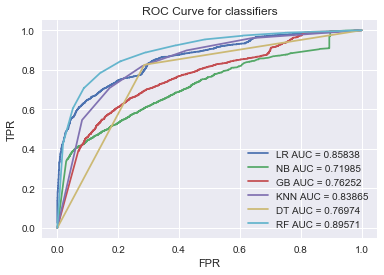

In [85]:
# Running with Default Parameters
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Running Models with Default Parameters
for model, model_label in [(LogisticRegression(), "LR"), (BernoulliNB(), "NB"), (GaussianNB(), "GB"), \
                           (KNeighborsClassifier(), "KNN"), (DecisionTreeClassifier(), "DT"), \
                           (RandomForestClassifier(), "RF")]:
    # Fit the model
    model.fit(train_df.drop('Opioid.Prescriber',1), train_df['Opioid.Prescriber'])
    # Predictions
    predictions = model.predict_proba(test_df.drop('Opioid.Prescriber',1))[:, 1]
    # Calculate roc metrics
    fpr, tpr, thresholds = metrics.roc_curve(test_df['Opioid.Prescriber'], predictions)
    auc = metrics.roc_auc_score(test_df['Opioid.Prescriber'], predictions)
    # Plotting the AUC curve for both classifiers and both the binary and tfidf feature sets
    plt.plot(fpr, tpr, label=model_label + " AUC = " + str(round(auc, 5)))
    # Labelling Axes and Title
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve for classifiers")
plt.legend()
plt.show()

<div style="color:blue">
Fit the model to predict Opioid.Prescriber and perform basic initial evaluations.  
The LR, KNN and Random Forest models are better at ranking the test set than the other models by comparing their AUC scores.  
Let's verify our Model Performance results using Cross Validation.
</div>

# Model Selection with Cross Validation and Hyper-Parameter Tuning

In [87]:
# Without using Hyperparameter tuning
# With 'Gender' included
# Remove Target Variable Opioid.Prescriber
features = train_df.iloc[:,0:242]
target = train_df['Opioid.Prescriber']

Name=[]
Accuracy=[]

# Defining Models with Default Parameters
log_reg_model = LogisticRegression()
gaussian_nb_model = GaussianNB()
ber_nb_model = BernoulliNB()
knn_model = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

# Running Models with Default Parameters and Cross-Validation
for model, label in zip([log_reg_model, gaussian_nb_model, ber_nb_model, knn_model, decision_tree, random_forest], \
                        ['Logistic Regression','Naive Bayes','Bernoulli NB', 'KNN', 'Decision Tree', 'Random Forest']):
    # Evaluate Model Score by performing 5-fold Cross-Validation
    scores = cross_val_score(model, features, target, cv=5, scoring='accuracy')
    # Consider Mean of Model Scores
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.762609 of model Logistic Regression
Accuracy: 0.612056 of model Naive Bayes
Accuracy: 0.625385 of model Bernoulli NB
Accuracy: 0.778765 of model KNN
Accuracy: 0.780027 of model Decision Tree
Accuracy: 0.820367 of model Random Forest


In [88]:
# Without using Hyperparameter tuning
# Gender not included
# Remove Target Variable Opioid.Prescriber

features = train_df.iloc[:,1:242]
target = train_df['Opioid.Prescriber']

Name=[]
Accuracy=[]

# Defining Models with Default Parameters
log_reg_model = LogisticRegression()
gaussian_nb_model = GaussianNB()
ber_nb_model = BernoulliNB()
knn_model = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

# Running Models with Default Parameters and Cross-Validation
for model, label in zip([log_reg_model, gaussian_nb_model, ber_nb_model, knn_model, decision_tree, random_forest], \
                        ['Logistic Regression','Naive Bayes','Bernoulli NB', 'KNN', 'Decision Tree', 'Random Forest']):
    # Evaluate Model Score by performing 5-fold Cross-Validation
    scores = cross_val_score(model, features, target, cv=5, scoring='accuracy')
    # Consider Mean of Model Scores
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.760842 of model Logistic Regression
Accuracy: 0.612157 of model Naive Bayes
Accuracy: 0.625485 of model Bernoulli NB
Accuracy: 0.778462 of model KNN
Accuracy: 0.781441 of model Decision Tree
Accuracy: 0.824153 of model Random Forest


<div style="color:blue">
We can see a very little improvement in all classifiers except Logistic Regression after removing `Gender`.
</div>

## Hyperparameter Tuning using GridSearchCV and RandomSearchCV  
<br/>
<div style="color:blue">
We will attempt on improving our best 4 classifers using hyperparameter tuning
</div>

### Logistic Regression Parameter Tuning

In [111]:
from sklearn.model_selection import GridSearchCV

# Create logistic regression
log_reg_model = LogisticRegression()
# Solver
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# Create regularization hyperparameter space
C = [10**i for i in range(-8,2)]
# Create hyperparameter options
hyperparameters = dict(C=C, solver=solver)
# Create grid search using 5-fold cross validation
clf = GridSearchCV(log_reg_model, hyperparameters, cv=5, verbose=0)
# Fit grid search
best_model = clf.fit(train_df.drop('Opioid.Prescriber',1), train_df['Opioid.Prescriber'])
# View best hyperparameters
print ("Best Parameter Setting:\n")
print('(C = '+str(best_model.best_estimator_.get_params()['C'])+', solver = '+str(best_model.best_estimator_.get_params()['solver'])+")")

Best Parameter Setting:

(C = 0.0001, solver = newton-cg)


### KNN Classifier Parameter Tuning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

#Hyper Parameters Set
random_grid = {'n_neighbors':[5,6,7,8,9],
              'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'n_jobs':[-1]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
knn_model = KNeighborsClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
knn_random = RandomizedSearchCV(estimator = knn_model, param_distributions = random_grid, n_iter = 1, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
knn_random.fit(train_df.drop('Opioid.Prescriber',1), train_df['Opioid.Prescriber'])
knn_random.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree 
[CV] weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree 
[CV] weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree 
[CV] weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree 
[CV]  weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree, total=  51.5s
[CV] weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree 
[CV]  weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree, total=  51.9s
[CV]  weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree, total=  52.8s
[CV]  weights=uniform, n_neighbors=6, n_jobs=-1, leaf_size=3, algorithm=kd_tree, total=  53.6s


### Decision Tree Parameter Tuning

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_features = randint(1, 9)
min_samples_leaf = randint(1, 9)
min_samples_split = randint(2, 9)
criterion = ["gini", "entropy"]
random_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_leaf": min_samples_leaf,
              "min_samples_split":min_samples_split,
              "criterion": criterion}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
decision_tree = DecisionTreeClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = decision_tree, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dt_random.fit(train_df.drop('Opioid.Prescriber',1), train_df['Opioid.Prescriber'])
dt_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4 
[CV] criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4 
[CV] criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4 
[CV]  criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4, total=   0.1s
[CV]  criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4, total=   0.1s
[CV] criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4 
[CV] criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4 
[CV]  criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4, total=   0.1s
[CV]  criterion=gini, max_depth=40, max_features=5, min_samples_leaf=7, min_samples_split=4, total=   0.1s
[CV] criterion=entropy, max_depth=50, max_feature

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s


[CV] criterion=gini, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8 
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, total=   0.0s
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8 
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8 
[CV] criterion=entropy, max_depth=30, max_features=4, min_samples_leaf=7, min_samples_split=5 
[CV]  criterion=gini, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=8, total=   0.1s
[CV]  criterion=entropy, max_depth=30, max_features=4, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] criterion=entropy, max_depth=30, max_features=4, min_samples_leaf=7, min_samples_split

[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=2, min_samples_split=5 
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=2, min_samples_split=5 
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=3 
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV]  criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=3, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=3 
[CV] criterion=entropy, max_depth=20, max_features=2, min_samples_leaf

[CV] criterion=entropy, max_depth=80, max_features=8, min_samples_leaf=7, min_samples_split=4 
[CV]  criterion=entropy, max_depth=80, max_features=8, min_samples_leaf=7, min_samples_split=4, total=   0.1s
[CV] criterion=entropy, max_depth=80, max_features=8, min_samples_leaf=7, min_samples_split=4 
[CV]  criterion=entropy, max_depth=80, max_features=8, min_samples_leaf=7, min_samples_split=4, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=8, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=entropy, max_depth=80, max_features=8, min_samples_leaf=7, min_samples_split=4, total=   0.1s
[CV]  criterion=gini, max_depth=10, max_features=8, min_samples_leaf=3, min_samples_split=4, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=8, min_samples_leaf=3, min_samples_split=4 
[CV] criterion=gini, max_depth=10, max_features=8, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=gini, max_depth=10, max_features=8, min_samples_leaf=3, min_samples_split=4, tota

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.8s


[CV] criterion=gini, max_depth=50, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV]  criterion=gini, max_depth=50, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV] criterion=gini, max_depth=50, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV] criterion=gini, max_depth=50, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV]  criterion=gini, max_depth=50, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV] criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=1, min_samples_split=8 
[CV]  criterion=gini, max_depth=50, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV] criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=1, min_samples_split=8 
[CV]  criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=1, min_samples_split=8, total=   0.1s
[CV] criterion=entropy, max_depth=70, max_features=3, min_samples_leaf=1, min_samples_split=8 
[CV]  cr

[CV]  criterion=gini, max_depth=50, max_features=6, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] criterion=gini, max_depth=50, max_features=6, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=50, max_features=6, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV]  criterion=gini, max_depth=50, max_features=6, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] criterion=entropy, max_depth=40, max_features=6, min_samples_leaf=6, min_samples_split=4 
[CV]  criterion=entropy, max_depth=40, max_features=6, min_samples_leaf=6, min_samples_split=4, total=   0.1s
[CV] criterion=entropy, max_depth=40, max_features=6, min_samples_leaf=6, min_samples_split=4 
[CV] criterion=entropy, max_depth=40, max_features=6, min_samples_leaf=6, min_samples_split=4 
[CV]  criterion=entropy, max_depth=40, max_features=6, min_samples_leaf=6, min_samples_split=4, total=   0.1s
[CV] criterion=entropy, max_depth=40, max_features=6, min_samples_leaf=6, min_samp

[CV]  criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] criterion=entropy, max_depth=10, max_features=2, min_samples_leaf

[CV] criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=gini, max_depth=110, max_features=8, min_samples_leaf=3, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5 
[CV] criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5, total=   0.3s
[CV] criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5, total=   0.3s
[CV]  criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5, total=   0.3s
[CV] criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=gini, max_depth=60, max_features=8, min_samples_leaf=5, min_samples_split=5, total=   0.2s
[CV]

[CV] criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV] criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV]  criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV] criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV]  criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV]  criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV] criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV]  criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV] criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8 
[CV]  criterion=gini, max_depth=90, max_features=2, min_samples_leaf=7, min_samples_split=8, total=   0.1s
[CV] 

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   30.3s


[CV]  criterion=entropy, max_depth=10, max_features=8, min_samples_leaf=4, min_samples_split=4, total=   0.1s
[CV] criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5 
[CV] criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV]  criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5 
[CV] criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV]  criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] criterion=gini, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=5 
[C

[CV] criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4 
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4, total=   0.1s
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4, total=   0.1s
[CV] criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4 
[CV] criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4 
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4, total=   0.1s
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4, total=   0.1s
[CV] criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_samples_split=4 
[CV] criterion=entropy, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=3 
[CV]  criterion=entropy, max_depth=60, max_features=6, min_samples_leaf=5, min_sample

[CV] criterion=gini, max_depth=40, max_features=7, min_samples_leaf=5, min_samples_split=6 
[CV]  criterion=gini, max_depth=40, max_features=7, min_samples_leaf=5, min_samples_split=6, total=   0.1s
[CV] criterion=gini, max_depth=40, max_features=7, min_samples_leaf=5, min_samples_split=6 
[CV]  criterion=gini, max_depth=40, max_features=7, min_samples_leaf=5, min_samples_split=6, total=   0.1s
[CV]  criterion=gini, max_depth=40, max_features=7, min_samples_leaf=5, min_samples_split=6, total=   0.1s
[CV] criterion=gini, max_depth=40, max_features=7, min_samples_leaf=5, min_samples_split=6 
[CV] criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=8, min_samples_split=4 
[CV]  criterion=gini, max_depth=40, max_features=7, min_samples_leaf=5, min_samples_split=6, total=   0.1s
[CV]  criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=8, min_samples_split=4, total=   0.1s
[CV] criterion=entropy, max_depth=70, max_features=1, min_samples_leaf=8, min_samples_split

[CV]  criterion=gini, max_depth=100, max_features=7, min_samples_leaf=2, min_samples_split=4, total=   0.1s
[CV]  criterion=gini, max_depth=100, max_features=7, min_samples_leaf=2, min_samples_split=4, total=   0.1s
[CV] criterion=gini, max_depth=100, max_features=7, min_samples_leaf=2, min_samples_split=4 
[CV]  criterion=gini, max_depth=100, max_features=7, min_samples_leaf=2, min_samples_split=4, total=   0.1s
[CV] criterion=gini, max_depth=100, max_features=7, min_samples_leaf=2, min_samples_split=4 
[CV] criterion=entropy, max_depth=90, max_features=8, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=gini, max_depth=100, max_features=7, min_samples_leaf=2, min_samples_split=4, total=   0.1s
[CV]  criterion=entropy, max_depth=90, max_features=8, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] criterion=entropy, max_depth=90, max_features=8, min_samples_leaf=5, min_samples_split=5 
[CV] criterion=entropy, max_depth=90, max_features=8, min_samples_leaf=5, min_samp

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.0s finished


{'criterion': 'gini',
 'max_depth': 110,
 'max_features': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

### Random Forest Parameter Tuning

In [76]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
random_forest = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_df.drop('Opioid.Prescriber',1), train_df['Opioid.Prescriber'])
rf_random.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=  10.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=  10.6s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=Fals

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.7min finished


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

### Modeling using Hyperparameter tuning

In [96]:
# Using hyperparameters
# With 'Gender' included
# Remove Target Variable Opioid.Prescriber
features = train_df.iloc[:,0:242]
target = train_df['Opioid.Prescriber']

Name=[]
Accuracy=[]

# Defining Models with Hyperparameters Parameters
log_reg_model = LogisticRegression(random_state=22,C=0.0001,solver='newton-cg',max_iter=200)
knn_model = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 110, max_features = 8,\
                                       min_samples_leaf = 3, min_samples_split = 2)
random_forest = RandomForestClassifier(bootstrap = False, max_depth = 80, max_features = 'auto', \
                                       min_samples_leaf = 1, min_samples_split = 10, n_estimators = 1000)

# Running Models with Hyper Parameters and Cross-Validation
for model, label in zip([log_reg_model, knn_model, decision_tree, random_forest], \
                        ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']):
    # Evaluate Model Score by performing 5-fold Cross-Validation
    scores = cross_val_score(model, features, target, cv=5, scoring='accuracy')
    # Consider Mean Model Scores
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.765335 of model Logistic Regression
Accuracy: 0.778765 of model KNN
Accuracy: 0.774878 of model Decision Tree
Accuracy: 0.836674 of model Random Forest


In [99]:
# Using hyperparameters
# Gender not included
# Remove Target Variable Opioid.Prescriber

features = train_df.iloc[:,1:242]
target = train_df['Opioid.Prescriber']

Name=[]
Accuracy=[]

# Defining Models with Hyperparameters Parameters
log_reg_model=LogisticRegression(random_state=22,C=0.0001,solver='newton-cg',max_iter=200)
knn_model = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 110, max_features = 8,\
                                       min_samples_leaf = 3, min_samples_split = 2)
random_forest = RandomForestClassifier(bootstrap = False, max_depth = 80, max_features = 'auto', \
                                       min_samples_leaf = 1, min_samples_split = 10, n_estimators = 1000)

# Running Models with Hyper Parameters and Cross-Validation
for model, label in zip([log_reg_model, knn_model, decision_tree, random_forest], \
                        ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']):
    # Evaluate Model Score by performing 5-fold Cross-Validation
    scores = cross_val_score(model, features, target, cv=5, scoring='accuracy')
    # Consider Mean Model Scores
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.765133 of model Logistic Regression
Accuracy: 0.778462 of model KNN
Accuracy: 0.775686 of model Decision Tree
Accuracy: 0.835866 of model Random Forest


<div style="color:blue" align="center">
<b>Model Performance (Considering Gender)</b>
<table>
  <tr>
    <th>Model</th>
    <th>Accuracy (Default Params)</th>
    <th>Accuracy (Parameter Tuning)</th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>0.762609</td>
    <td>0.765335</td>
  </tr>
  <tr>
    <td>KNN Classifier</td>
    <td>0.778765</td>
    <td>0.778765</td>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>0.780027</td>
    <td>0.774878</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.820367</td>
    <td>0.836674</td>
  </tr>
</table>
<br/>
<b>Model Performance (Without Gender)</b>
<table>
  <tr>
    <th>Model</th>
    <th>Accuracy (Default Params)</th>
    <th>Accuracy (Parameter Tuning)</th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>0.760842</td>
    <td>0.765133</td>
  </tr>
  <tr>
    <td>KNN Classifier</td>
    <td>0.778462</td>
    <td>0.778462</td>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>0.781441</td>
    <td>0.775686</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.824153</td>
    <td>0.835866</td>
  </tr>
</table>
</div>

In [37]:
from sklearn.model_selection import KFold

# Takes as inputs a dataset, a label name, # of splits/folds (k), a sequence of values for  CC  (cs)
def xValSVM(dataset, label_name, k, cs, model):

    # Removing Target Variable from dataset and storing it seperately
    data = dataset.drop(label_name, axis=1)
    target = dataset[label_name]
    aucs = {}
    
    for f in range(2,k):
        cross_val = KFold(n_splits = f)
        
        # Split the data into data_train & data_validate 
        for data_train_index, data_validate_index in cross_val.split(X=data, y=target):
            data_train = dataset.iloc[data_train_index]
            data_validate = dataset.iloc[data_validate_index]
            
            for c in cs:
                # Fit the Model
                model.fit(data_train.drop(label_name, axis=1),data_train[label_name])
                # Predicting Labels, Calculating FPR, TPR, Thresholds and ROC Value using SVM Model
                predictions = model.predict_proba(data_validate.drop(label_name, axis=1))[:, 1]
                fpr, tpr, thresholds = metrics.roc_curve(data_validate[label_name], predictions)
                # Computes AUC_c_k on validation data
                AUC_c_k = metrics.roc_auc_score(data_validate[label_name], predictions)
                # Stores AUC_c_k in a dictionary of values
                if c in aucs:
                    aucs[c].append(AUC_c_k)
                else:
                    aucs[c] = [AUC_c_k]
                break
            break
    
    # Returns a dictionary, where each key-value pair is: c:[auc-c1,auc-c2,..auc-ck]
    return aucs

In [38]:
# Generate a sequence of 10C  values in the interval [10^(-8), ..., 10^1] (i.e., do all powers of 10 from -8 to 1).
cs = [10**i for i in range(-8,2)]

log_reg_model=LogisticRegression(random_state=22,C=0.0001,solver='newton-cg',max_iter=200)
knn_model = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 110, max_features = 8,\
                                       min_samples_leaf = 3, min_samples_split = 2)
random_forest = RandomForestClassifier(bootstrap = False, max_depth = 80, max_features = 'auto', \
                                       min_samples_leaf = 1, min_samples_split = 10, n_estimators = 1000)

Name=[]
Model_AUC=[]

for model, label in zip([log_reg_model, knn_model, decision_tree, random_forest], \
                        ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']):
    # Cross-Validation
    aucs = xValSVM(train_df, 'Opioid.Prescriber', 10 , cs, model)
    mean_auc = pd.DataFrame(aucs).mean().mean()
    max_auc = pd.DataFrame(aucs).max().max()
    Model_AUC.append(mean_auc)
    Name.append(model.__class__.__name__)
    print("Mean AUC achieved: %f of model %s" % (mean_auc,label))
    print("Max AUC achieved: %f of model %s" % (max_auc,label))

Mean AUC achieved: 0.852759 of model Logistic Regression
Max AUC achieved: 0.857426 of model Logistic Regression
Mean AUC achieved: 0.748024 of model Naive Bayes
Max AUC achieved: 0.756834 of model Naive Bayes
Mean AUC achieved: 0.705855 of model Bernoulli NB
Max AUC achieved: 0.715753 of model Bernoulli NB
Mean AUC achieved: 0.826388 of model KNN
Max AUC achieved: 0.833309 of model KNN
Mean AUC achieved: 0.760982 of model Decision Tree
Max AUC achieved: 0.766457 of model Decision Tree
Mean AUC achieved: 0.911282 of model Random Forest
Max AUC achieved: 0.915900 of model Random Forest


<div style="color:blue;">
<b>Model Performance (Considering Gender)</b>
<table>
  <tr>
    <th>Model</th>
    <th>Mean AUC</th>
    <th>Max AUC</th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>0.852759</td>
    <td>0.857426</td>
  </tr>
  <tr>
    <td>KNN Classifier</td>
    <td>0.826388</td>
    <td>0.833309</td>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>0.760982</td>
    <td>0.766457</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.911282</td>
    <td>0.915900</td>
  </tr>
</table>
<br/>
From hyperparameter tuning, we saw a significant improvement in Random Forest (+~1.6%).
After applying the hyperparmaters to calculate AUC Scores of each model, based on accuracy and AUC Metrics, we found that Random Forest does well with 0.91 mean AUC Score and 0.84 Accuracy. Therefore, we choose Random Forest for Model Evaluation.
</div>

## Model Evaluation

In [101]:
testset_df = test_df.drop('Opioid.Prescriber',1) 
testset_df = testset_df.drop('Gender',1) 
testset_df.head()

,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
6080,15,85,11,0,0,0,0,0,48,0,...,0,0,0,0,0,0,0,0,0,28
7682,36,35,0,0,0,0,90,0,17,0,...,0,0,0,0,0,0,49,0,0,35
5028,4,85,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,0
17750,34,74,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12153,45,62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20,0,0,0,0


In [105]:
# Running Random Forest
from sklearn.metrics import accuracy_score
# Define Model with Hyperparameters
random_forest = RandomForestClassifier(bootstrap = False, max_depth = 80, max_features = 'auto', \
                                       min_samples_leaf = 1, min_samples_split = 10, n_estimators = 1000)
# Fit the Model
model = random_forest.fit(features, target)
# Run Predictions
predictions = model.predict(testset_df)
# Get Accuracy Metrics
accuracy = accuracy_score(test_df['Opioid.Prescriber'],pred)
print("Out Sample Accuracy of Random Forest = ", accuracy)

Out Sample Accuracy of Random Forest =  0.842891760904685


In [106]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
actuals = test_df['Opioid.Prescriber']
confusion_matrix(actuals, predictions)

array([[1599,  452],
       [ 333, 2568]])

In [109]:
# Precision-Recall Score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(actuals, predictions)

print('Average Precision-Recall Score = {0:0.2f}'.format(average_precision))

Average Precision-Recall Score = 0.82


Text(0.5,1,'2-class Precision-Recall curve: AP=0.82')

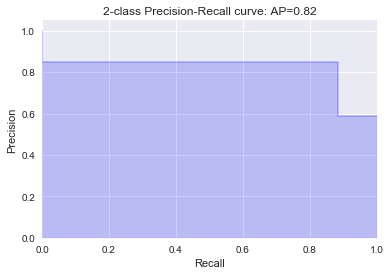

In [110]:
# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(actuals, predictions)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))